In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from keras import layers
from keras.utils import plot_model
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 32
DATA_DIR = "../data"

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
])


train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 3206 files belonging to 3 classes.
Using 2565 files for training.
Found 3206 files belonging to 3 classes.
Using 641 files for validation.
Found 363 files belonging to 2 classes.


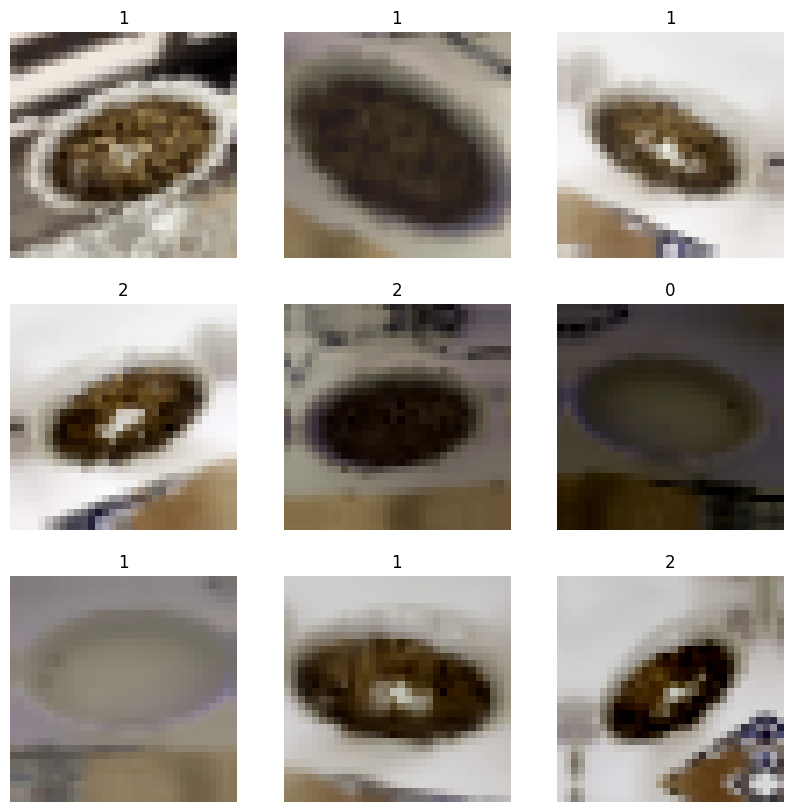

In [3]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

plt.show()

In [4]:
IMG_SIZE = 32

model = keras.Sequential([
    keras.layers.Rescaling(1/255.0, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


C:\Users\silva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6647 - loss: -11.3410 - val_accuracy: 0.6490 - val_loss: -60.0051
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6647 - loss: -662.8124 - val_accuracy: 0.6490 - val_loss: -2277.0364
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6647 - loss: -7649.9585 - val_accuracy: 0.6490 - val_loss: -17276.7598
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6647 - loss: -39275.9648 - val_accuracy: 0.6490 - val_loss: -72006.5391
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6647 - loss: -119180.7266 - val_accuracy: 0.6490 - val_loss: -197351.0156
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6647 - loss: -299958.1562 - val_accuracy: 0.6490 - val_loss: -462906.7188
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6647 - loss: -653275.6875 - val_accuracy: 0.6490 - val_loss: -977588.9375
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms

In [6]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4986 - loss: 29851764.0000


[29851764.0, 0.4986225962638855]

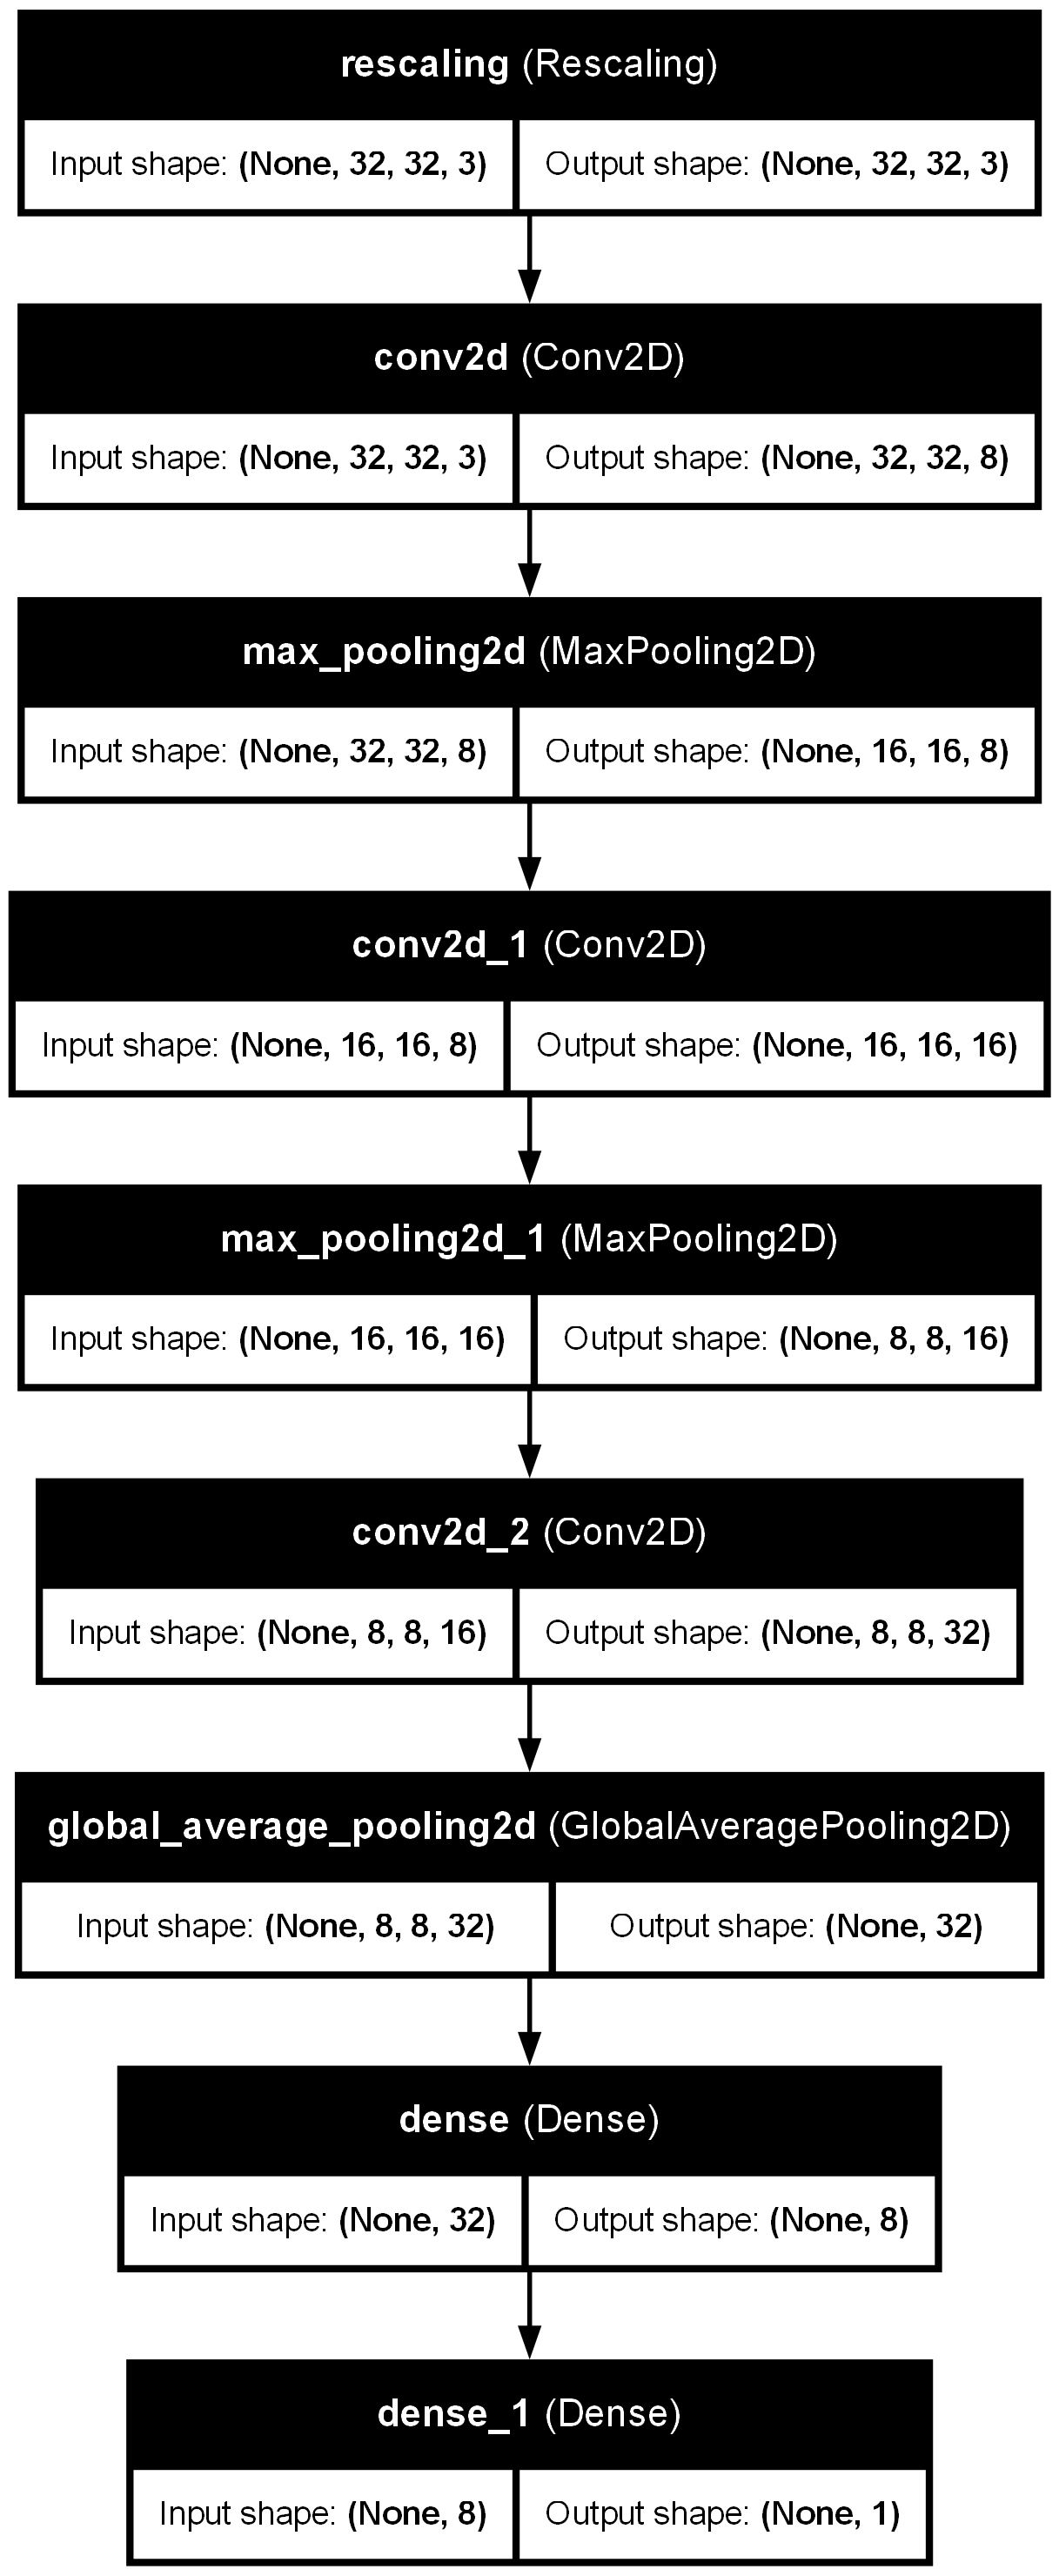

In [8]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=200
)

In [ ]:
model.export("saved_model")

# Convert to .tflite (float)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("catbowl4.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved catbowl.tflite")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2212049242064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049246480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049246288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049246864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049246672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049240720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049242640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049247056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049242448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212049242256: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved catbowl.tflite
